# Laboratorio 4

Sean bienvenidos de nuevo al laboratorio 4 de Deep Learning y Sistemas Inteligentes. Así como en los laboratorios pasados, espero que esta ejercitación les sirva para consolidar sus conocimientos en el tema de Encoder-Decoder y AutoEnconders.

Para este laboratorio estaremos usando una herramienta para Jupyter Notebooks que facilitará la calificación, no solo asegurándo que ustedes tengan una nota pronto sino también mostrandoles su nota final al terminar el laboratorio.

Espero que esta vez si se muestren los *marks*. De nuevo me discupo si algo no sale bien, seguiremos mejorando conforme vayamos iterando. Siempre pido su comprensión y colaboración si algo no funciona como debería. 

Al igual que en el laboratorio pasado, estaremos usando la librería de Dr John Williamson et al de la University of Glasgow, además de ciertas piezas de código de Dr Bjorn Jensen de su curso de Introduction to Data Science and System de la University of Glasgow para la visualización de sus calificaciones. 

**NOTA:** Ahora tambien hay una tercera dependecia que se necesita instalar. Ver la celda de abajo por favor

<script type="text/javascript" src="https://cdn.mathjax.org/mathjax/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML">
</script>

In [1]:
# Una vez instalada la librería por favor, recuerden volverla a comentar.
#!pip install -U --force-reinstall --no-cache https://github.com/johnhw/jhwutils/zipball/master
#!pip install scikit-image
#!pip install -U --force-reinstall --no-cache https://github.com/AlbertS789/lautils/zipball/master

In [2]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import scipy
from PIL import Image
import os
from collections import defaultdict

#from IPython import display
#from base64 import b64decode


# Other imports
from unittest.mock import patch
from uuid import getnode as get_mac

from jhwutils.checkarr import array_hash, check_hash, check_scalar, check_string, array_hash, _check_scalar
import jhwutils.image_audio as ia
import jhwutils.tick as tick
from lautils.gradeutils import new_representation, hex_to_float, compare_numbers, compare_lists_by_percentage, calculate_coincidences_percentage

###
tick.reset_marks()

%matplotlib inline

In [3]:
# Seeds
seed_ = 2023
np.random.seed(seed_)

In [4]:
# Celda escondida para utlidades necesarias, por favor NO edite esta celda


###### Información del estudiante en dos variables

* carne_1 : un string con su carne (e.g. "12281"), debe ser de al menos 5 caracteres.
* firma_mecanografiada_1: un string con su nombre (e.g. "Albero Suriano") que se usará para la declaracion que este trabajo es propio (es decir, no hay plagio)
* carne_2 : un string con su carne (e.g. "12281"), debe ser de al menos 5 caracteres.
* firma_mecanografiada_2: un string con su nombre (e.g. "Albero Suriano") que se usará para la declaracion que este trabajo es propio (es decir, no hay plagio)

In [5]:
carne_1 = "21371"
firma_mecanografiada_1 = "Sara Echeverria"
carne_2 = "21371"
firma_mecanografiada_2 = "Sara Echeverria"

In [6]:
# Deberia poder ver dos checkmarks verdes [0 marks], que indican que su información básica está OK 

with tick.marks(0): 
    assert(len(carne_1)>=5 and len(carne_2)>=5)

with tick.marks(0):  
    assert(len(firma_mecanografiada_1)>0 and len(firma_mecanografiada_2)>0)

## Parte 1 - Word2Vec

**Créditos:** La primera parte de este laboratorio está tomado y basado en uno de los post de Musashi (Jacobs-) Harukawa

La eficacia de las técnicas de embedding está directamente relacionada con los desafíos iniciales que motivaron los enfoques de texto como datos. Al convertir el lenguaje natural en representaciones numéricas, los métodos de incrustación abren oportunidades para aplicar varias herramientas cuantitativas a fuentes de datos previamente sin explotar.

En términos generales, word embedding representa cada palabra en un conjunto dado de textos (corpus) como vectores en un espacio k-dimensional (donde k es elegido por el investigador; más detalles sobre esto más adelante). Estos vectores contienen información valiosa sobre las relaciones de las palabras y su contexto, sirviendo como herramientas esenciales para las tareas posteriores de modelado del lenguaje.

Entonces, es entendible que se pregunten

* ¿Cómo funciona este proceso de incrustación?
* ¿Cuál es la razón subyacente de su éxito?
* ¿Cómo podemos determinar su eficacia?

Para poder responder las primeras dos preguntas, vamos a implementar este modelo usando PyTorch. Noten que el state-of-the-art ya no solo se usa Word2Vec, como BERT (Bidirectional Encoder Representations from Transformers). Pero siempre es un buen ejercicio entender estos algoritmos.

### Paso 1 - DataLoader

Como en laboratorios, lo primero que necesitamos es definir un DataLoader. Para esta primera parte estaremos usando el dataset llamado "tweets_hate_speech_detection" de HugginFace.

Para esto necesitamos una función que separe los textos en listas de tokens. El preprocesamiento para cuando se trabaja con textos debe ser un poco más exhaustivo de lo que haremos en este laboratorio, pero para fines del mismo solamente haremos:

1- Pasar a minusculas

2- Quitar todos los simbolos diferentes de a-z@#

3- Separar en espacios

4- Quitar "stopword" y tokens vacíos

5- Aplicar snowball stemmer al resto (snowball? sí, refieran a la nota de abajo para la explicación rápida)

Para esto nos apoyaremos en el paquete de natural language processing toolkit o nltk para los cuates. Entonces, recuerden instalarlo por favor "pip install nltk"

**Snowball Stemmer** es un modulo en la librería NLTK que implementa la técnica de stemming. ¿Stemming?
Stemming es una técnica utilizada para extraer la forma base de las palabras mediante la eliminación de los (pre-post)fijos de ellos. Imaginen que cortan la ramas de un árbol hasta los tallos. Por ejemplo, la raíz de las palabras comiendo, come, comido es comer. Refieran a este [link](https://www.tutorialspoint.com/natural_language_toolkit/natural_language_toolkit_stemming_lemmatization.htm) para más información

In [7]:
import torch
import datasets

dataset = datasets.load_dataset('tweets_hate_speech_detection', trust_remote_code=True)

In [8]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

# Download the stopwords dataset
nltk.download('stopwords')

ss = SnowballStemmer('english')
sw = stopwords.words('english')

def split_tokens(row):
    # 1- Pasar a minusculas
    tweet_lower = row['tweet'].lower()
    
    # 2- Quitar todos los simbolos diferentes de a-z@#
    tweet_cleaned = re.sub(r"[^a-z@# ]", "", tweet_lower)
    
    # 3- Separar en espacios
    tweet_tokens = re.split(r" +", tweet_cleaned)
    
    # 4- Quitar "stopword" y tokens vacíos
    # 5- Aplicar snowball stemmer al resto 
    filtered_tokens = [ss.stem(i) for i in tweet_tokens if (i not in sw) and len(i)]
    
    row['all_tokens'] = filtered_tokens
    
    return row

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sarap\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
# Determinamos el vocabulario
dataset = dataset.map(split_tokens)

Ahora podemos crear algunas variables que nos serán útiles en futuros pasos. Además, debemos quitar los tokens que ocurren menos de 10 veces para reducir el tamaño del vocabulario

In [10]:
from collections import Counter

# Total de palabras

counts = Counter([i for s in dataset['train']['all_tokens'] for i in s])
counts = {k:v for k, v in counts.items() if v>10} # Filtering

# Aprox 1 linea para obtener los tokens unicos
vocab = list(counts.keys())

# Aprox 1 linea para determinar el tamaño del vocabulario
vocab_size = len(vocab)
n_v = vocab_size  # Define n_v

# Aprox 2 lineas para definir 
#     los diccionarios para ir de un token a un id numérico y viceversa
id2tok = {i: tok for i, tok in enumerate(vocab)}
tok2id = {tok: i for i, tok in enumerate(vocab)}

# Funcion para quitar tokens "raros"
def remove_rare_tokens(row):
    row['tokens'] = [t for t in row['all_tokens'] if t in vocab]
    return row

dataset = dataset.map(remove_rare_tokens)

In [11]:
dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'tweet', 'all_tokens', 'tokens'],
        num_rows: 31962
    })
    test: Dataset({
        features: ['label', 'tweet', 'all_tokens', 'tokens'],
        num_rows: 17197
    })
})

In [12]:
with tick.marks(3):        
    assert(check_scalar(len(counts), '0xf4f4eb83'))
    
with tick.marks(3):        
    assert(check_scalar(len(id2tok), '0xf4f4eb83'))
    
with tick.marks(3):        
    assert(check_scalar(len(vocab), '0xf4f4eb83'))
    
with tick.marks(3):        
    assert(check_scalar(n_v, '0xf4f4eb83'))
    
with tick.marks(3):        
    assert(check_scalar(tok2id['father'], '0xb44c37ea'))
    
with tick.marks(3):        
    assert(check_string(id2tok[1], '0xcf2531b8'))

Ahora, recordemos que Word2Vec ayuda a representar una palabra por su contexto, para ello necesitamos definir una ventana movil (sliding window) que se usa dentro del algoritmo. Esta consiste en tomar cada palabra de una frase, y luego se parea con las N palabras más cercanas (hacia la derecha e izquierda). Por ejemplo, consideremos una frase como "every good dog does fine", con una ventana de 2. El resultado sería algo como:

`(every, good)`
`(every, dog)`
`(good, every)`
`(good, dog)`
`(good, does)`
`(dog, every)`
`(dog, good)`
`...`

Y así consecutivamente. La frase u oración, es convertida en un par `target, context` donde el contex es una lista de tokens dentro de la ventana.

Luego, definiremos el DataSet usando las clases correspondiente como lo hemos hecho antes.

In [13]:
def windowizer(row, wsize=3):
    """
    Windowizer function for Word2Vec. Converts sentence to sliding-window
    pairs.
    """
    doc = row['tokens']
    out = []
    
    for i, word in enumerate(doc):
        target = tok2id[word]
        
        # 1 - Definimos el rango de la ventana movil
        window = [i + j for j in range(-wsize, wsize + 1, 1) if (i + j >= 0) & (i + j < len(doc)) & (j != 0)]
        
        # 2 - Creamos pares de la ventana movil
        window_pairs = [(target, tok2id[doc[w]]) for w in window]
        
        # 3 - Agregamos los pares a la lista de salida
        out += window_pairs
        
    # 4 - Asingamos el "movin_window" a la fila
    row['moving_window'] = out
    
    return row

dataset = dataset.map(windowizer)

Map:   0%|          | 0/31962 [00:00<?, ? examples/s]

Map:   0%|          | 0/17197 [00:00<?, ? examples/s]

In [14]:
with tick.marks(5):        
    assert(check_scalar(dataset["train"].num_rows, '0xcd61d16b'))

In [15]:
#from torch.utils.data import Dataset, DataLoader
import torch
from torch.utils.data import TensorDataset, Dataset, DataLoader
 
    
class Word2VecDataset(Dataset):
    def __init__(self, dataset, vocab_size, wsize=3):
        self.dataset = dataset
        self.vocab_size = vocab_size
        self.data = [i for s in dataset['moving_window'] for i in s]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx][0], self.data[idx][1]
    

Ahora definiremos dos variables globales, el `BATCH_SIZE` y `N_LOADER_PROCS`.

`BATCH_SIZE` es el número de observaciones devueltas con cada llamada. Gran parte de las aceleraciones del procesamiento de GPU provienen de cálculos de matriz por batches masivos. Al elegir el tamaño del batch, recuerden que generalmente se trata de un trade-off entre el uso de VRAM y la velocidad, excepto cuando el Data Loader en sí es el cuello de botella. Para acelerar el DataLoader, podemos pasar un argumento a num_workers para habilitar la paralelización en la preparación y carga de datos.

In [16]:

# Create an instance of the Word2VecDataset
word2vec_dataset_ = Word2VecDataset(dataset['train'], vocab_size=n_v)

# Convert the Word2VecDataset into a TensorDataset
word2vec_dataset = TensorDataset(torch.tensor(word2vec_dataset_.data, dtype=torch.long))

BATCH_SIZE = 2**16
N_LOADER_PROCS = 5

dataloader_train = DataLoader(word2vec_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=N_LOADER_PROCS)

### Paso 2 - Construyendo la Red
La arquitectura que usaremos para esta ocasión será la dada por una versión de Word2Vec, esta consiste en:
* Tres capas: Input, hidden y output
* Tanto el tamaño de la input como la output son del tamaño del vocabulario. Pero la hidden es un poco más pequeña
* Todas son Fully Connected con Funciones de Activación Lineales

Como mencionamos en clase hay dos variantes
* CBOW (Continuous Bag of Words): El enfoque está dado en las palabras de contexto para dar énfasis a la palabra central. O en otras palabras, las palabras de contexto son el input y la palabra central son el output (Espero que esto haga más sentido de la explicación en clase)
* Skip-gram: La palabra central es el input, y las de contexto son la salida.

Definamos CBOW para este laboratorio...

Pero antes, debemos encodear nuestras palabras (otra vez como lo hicimos en el laboratorio pasado), esta implementación es similar a la que hicimos anteriormente, pero observen el uso de tensores. 

In [17]:
from torch import nn
import torch

size = 20
input_ = 7

def one_hot_encode(input_, size):
    vec = torch.zeros(size).float()
    vec[input_] = 1.0
    return vec

ohe = one_hot_encode(input_, size)
linear_layer = nn.Linear(size, 1, bias=False)

In [18]:
with tick.marks(3):        
    assert int(ohe[7])  == 1

Ahora, sobreescribamos el comportamiento natural de la inicializacion de pesos, para que estos en lugar de iniciar aleatoriamente, sean valores de 0 - size. Esto lo hacemos dentro `torch.no_grad()` para quitar el tracking de la gradiente (recuerden que cuando usamos los tensores de PyTorch la gradiente se le hace tracking, es decir que se almacenan para hacer la diferenciar la pérdida con respecto de cada parametro en el modelo. Debido a que en esta ocasion lo estamos seteando manualmente no queremos que se almacene y sea considerado en futuras backpropagations.

Observen como al pasar el vector encodeado a la capa nos devuelve efectivamente el número que corresponde en `linear_layer(ohe)`

In [19]:
with torch.no_grad():
    linear_layer.weight = nn.Parameter(
        torch.arange(size, dtype=torch.float).reshape(linear_layer.weight.shape))

print(linear_layer.weight)
print(linear_layer(ohe))

Parameter containing:
tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
         14., 15., 16., 17., 18., 19.]], requires_grad=True)
tensor([7.], grad_fn=<SqueezeBackward4>)


Ya que tenemos un mejor entendimiento de este tipo de layers en Word2Vec, debemos saber que PyTorch tiene una implementación más eficiente usando `nn.Embedding`, el cual toma los índices de input y regresa el peso del borde correspondiente a ese índice.

Un equivalente a lo que hemos hecho anteriormente sería lo que se presenta en la siguiente celda.

Noten como volvemos a obtener un tensor similar al que obtuvimos antes.

In [20]:
embedding_layer = nn.Embedding(size, 1)

with torch.no_grad():
    embedding_layer.weight = nn.Parameter(
        torch.arange(size, dtype=torch.float
        ).reshape(embedding_layer.weight.shape))

print(embedding_layer.weight)
print(embedding_layer(torch.tensor(input_)))

Parameter containing:
tensor([[ 0.],
        [ 1.],
        [ 2.],
        [ 3.],
        [ 4.],
        [ 5.],
        [ 6.],
        [ 7.],
        [ 8.],
        [ 9.],
        [10.],
        [11.],
        [12.],
        [13.],
        [14.],
        [15.],
        [16.],
        [17.],
        [18.],
        [19.]], requires_grad=True)
tensor([7.], grad_fn=<EmbeddingBackward0>)


Con esto en consideración, es momento de implementar nuestro modelo Word2Vec.

Noten el embedding_size, este corresponde a la cantidad de representaciones de cada palabra, como dijimos en clase, esto sería la cantidad de funciones de activaciones con las que trabajaremos.

Además, consideren las siguientes explicaciones

`self.embed`: Es una capa de embedding para convertir la entrada (el índice del token de centro/contexto) en la codificación one-hot, y luego recuperar los pesos correspondientes a estos índices en la capa hidden de menor dimensión.

`self.expand`: Es una capa lineal para predecir la probabilidad de una palabra de centro/contexto dada la hidden layer. Deshabilitamos el bias (la intercepción) porque cambiamos la escala de nuestras predicciones de todos modos.

`logits`: Este vuelve a expandir la capa hidden para hacer predicciones. Estas predicciones sin procesar deben volver a escalarse con softmax, pero omitimos este paso aquí, ya que PyTorch implementa los pasos relevantes en la Cross Entropy loss. 

In [21]:
class Word2Vec(nn.Module):
    def __init__(self, vocab_size, embedding_size):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embedding_size)
        self.expand = nn.Linear(embedding_size, vocab_size, bias=False)

    def forward(self, input_):
        # Pasamos el input a una representación más pequeña
        hidden = self.embed(input_)
        # Expandemos hacia las predicciones
        logits = self.expand(hidden)
        return logits

### Paso 3 - Entrenamiento (Training)


El entrenamiento en el contexto de las redes neuronales significa hacer predicciones repetidamente utilizando las observaciones en el conjunto de datos y luego ajustar los parámetros para corregir el error en las predicciones. 

Debido a que no queremos que la red aprenda perfectamente la predicción más reciente mientras olvida todas las demás predicciones, generalmente le damos un "learning rate", que es una penalización en el ajuste de pérdida para evitar que se ajuste solo a la observación más reciente. (Recuerden como funciona backpropgation)

Cuanto más tiempo entrenemos la red, con mayor perfección aprenderá los datos de entrenamiento, pero a menudo esto conlleva el riesgo de overfitting y no poder generalizar a datos no vistos. Sin embargo, dado que con Word2Vec nuestro objetivo no es inferir datos no vistos, sino describir datos "vistos", ¿cuál creen que es la implicación del overfitting en este tipo de modelos? (Más adelante se deja nuevamente la pregunta para que sea respondida)

In [22]:
# Algunos hyper parametros

# Demasiado pequeño pero es solo para fines de aprendizaje
EMBED_SIZE = 50 
model = Word2Vec(n_v, EMBED_SIZE)

# Traten de usar ya el CUDA si pueden por favor
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("Using:",device)
model.to(device)

# Otros parametros para el training
LR = 3e-4
EPOCHS = 3
loss_fn = nn.CrossEntropyLoss()
# Noten el tipo de optimizador que estamos usando :)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

Using: cpu


In [24]:
running_loss = []
for epoch in range(EPOCHS):
    epoch_loss = 0
    losses = []
    for ix, batch in enumerate(dataloader_train):
        print(f"Working with batch {ix}")
        for i in range(len(batch[0])):
            center = batch[0][i][0]
            context = batch[0][i][1]
            center, context = center.to(device), context.to(device)

            optimizer.zero_grad()  # Vaciar los gradientes

            logits = model(input_=context)  # Calcular los logits del modelo

            loss = loss_fn(logits, center)  # Calcular la pérdida

            losses.append(loss.item())
            loss.backward()  # Realizar backpropagation
            optimizer.step()  # Actualizar los parámetros del modelo
            
            if i % 6500 == 0:
                print(f"Done working with element {i}")
            
    epoch_loss = np.mean(losses)
    
    running_loss.append(epoch_loss)
    
    if epoch % 1 == 0:
        print(f'Epoch {epoch}, loss: {epoch_loss}')


Working with batch 0
Done working with element 0
Done working with element 6500
Done working with element 13000
Done working with element 19500
Done working with element 26000
Done working with element 32500
Done working with element 39000
Done working with element 45500
Done working with element 52000
Done working with element 58500
Done working with element 65000
Working with batch 1
Done working with element 0
Done working with element 6500
Done working with element 13000
Done working with element 19500
Done working with element 26000
Done working with element 32500
Done working with element 39000
Done working with element 45500
Done working with element 52000
Done working with element 58500
Done working with element 65000
Working with batch 2
Done working with element 0
Done working with element 6500
Done working with element 13000
Done working with element 19500
Done working with element 26000
Done working with element 32500
Done working with element 39000
Done working with elemen

In [25]:
with tick.marks(5):        
    assert compare_numbers(new_representation(running_loss[len(running_loss)-1]), "3c3d", '0x1.b000000000000p+2')

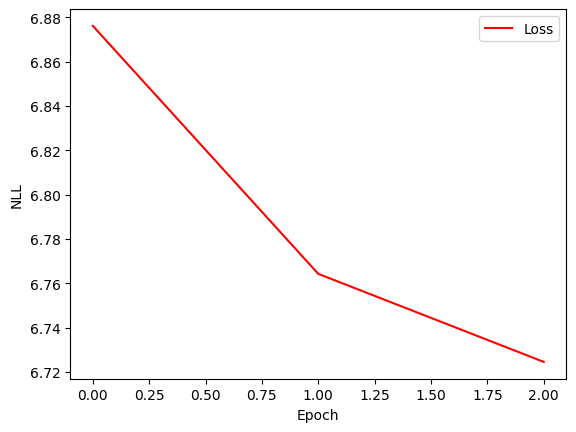

In [26]:
# Graficamos la perdida
epoch_ = np.arange(len(running_loss))
plt.figure()
plt.plot(epoch_, running_loss, 'r', label='Loss',)
plt.legend()
plt.xlabel('Epoch'), plt.ylabel('NLL')
plt.show()

Bueno, hemos visto la cantidad de tiemp que hay que invertirle para entrenar una red tan sencilla como la que se usa en Wor2Vec. En mi caso, usando CUDA le tomó alrededor de **42 minutos**. Ahora consideren aquel modelo donde no solo se sacan 50 representaciones de cada palabra sino miles, además que se entrenan por más epocas, no solo 3. 

Ahora veamos que tipo de palabras son las más cercanas a una pequeña muestra de 4 palabras. Para esto primero necesitamos sacar los pesos del modelo y pasarlos al cpu para trabajarlos como NumPy Arrays. Luego aplicaremos una función para encontrar la distancia dada una métrica (en este caso la distancia del coseno). 

In [ ]:
wordvecs = model.expand.weight.cpu().detach().numpy()
tokens = ['good', 'bad', 'school', 'day']

In [ ]:
from scipy.spatial import distance
import numpy as np

def get_distance_matrix(wordvecs, metric):
    dist_matrix = distance.squareform(distance.pdist(wordvecs, metric))
    return dist_matrix

def get_k_similar_words(word, dist_matrix, k=10):
    # Aprox 2 lineas para
    # idx = ...
    # dists = ... # Use la funcion dada arriba
    # Hint: tok2id
    # YOUR CODE HERE
    raise NotImplementedError()
    ind = np.argpartition(dists, k)[:k+1]
    ind = ind[np.argsort(dists[ind])][1:]
    out = [(i, id2tok[i], dists[i]) for i in ind]
    return out

dmat = get_distance_matrix(wordvecs, 'cosine')
for word in tokens:
    print(word, [t[1] for t in get_k_similar_words(word, dmat)], "\n")

**PREGUNTAS:**
* ¿Cuál es la implicación del overfitting en modelos como Word2Vec?
* ¿Qué tan bien encontró palabras cercanas su modelo Word2Vec? ¿Podría mejorar? ¿Cómo podría mejorar?
* A grandes rasgos, ¿cuál es la diferencia entre Word2Vec y BERT?

## Parte 2 - Encoder - Decoder

**Créditos:** La segunda parte de este laboratorio está tomado y basado en uno de los repositorios de Ben Trevett

En esta ocasión vamos a centrarnos en una arquitectura Sequence to Sequence (Seq2Seq), entonces estaremos desarrollando un modelo que nos ayude a traducir de alemán a inglés. Tomaremos como base el paper [Sequence to Sequence Learning with Neural Networks](https://arxiv.org/abs/1409.3215). Recuerden que a pesar que esto es para frases/oraciones, los conceptos pueden ser aplicados para otras arquitecturas similares.

**IMPORTANTE:** Recuerden usar virtual enviroments debido a que estaremos usando versiones viejas de la librerías. ¿Por qué? Las librerías eran un poco más explícitas que sus versiones más recientes. A continuación se dejan los comandos para la instalación de las más importantes

```
pip install -U torch==1.9.0+cu111 -f  https://download.pytorch.org/whl/cu111/torch_stable.html
pip install -U torchtext==0.10.0
```

El primer comando instalará la librería de PyTorch con CUDA 11.1
El segundo, instala TorchText en una versión donde la formulación del vocabulario para training, test y validation era más claro (esta es la principal por la que estamos usando esta versiones).


### Introducción
Los modelos más comunes seq2seq son los modelos *encoder-decoder*, los cuales usan una RNN para encodear el input y llevarlo a un solo vector. En este laboratorio nos estaremos refiriendo a dicho vector como *vector contexto*. Pensemos sobre el vector contexto como un ser abstracto que representa una frase completa. Este vector es luego decodeado por una segunda RNN, que aprende a generar la frase target (output) deseada al generar palabra por palabra. 


Consideren la siguiente ilustración para representar el proceso que estaremos realizando

<img src="https://raw.githubusercontent.com/bentrevett/pytorch-seq2seq/49df8404d938a6edbf729876405558cc2c2b3013/assets/seq2seq1.png" alt="Seq2Seq" />

*Crédito de imagen al autor, imagen tomada de "Sequence to Sequence Learning with Neural Networks" de Ben Trevett*

Noten como la frase de input "guten morgen", se pasa a través de una capa de embedding (cuadros amarillos) y luego entra en los encodeadores (cuadros verdes). En esta ocasión agregamos un token de "start of sequence" (`<sos>`) al inicio de la frase, además de un token de "end of sequence" (`<eos>`) al final de la oración. Vean como en cada paso, la entrada del encoder RNN es tanto la representación embedding $e$ de la palabra actual $e(x_t)$, así como el estado oculto del paso anterior $h_{t-1}$, y el encoder genera un nuevo hidden state $h_t$. Entonces, podemos pensar en el hidden state como una representación vectorial de la oración hasta ese momento. La RNN se puede representar como una función de tanto $e(x_t)$ y $h_{t-1}$

$$h_t = \text{EncoderRNN}(e(x_t), h_{t-1})$$

Por favor noten que estamos usando el termino RNN de forma general en este contexto, puede ser cualquier arquitectura como LSTM o GRU.

Entonces estaremos trabajando con una secuencia como $X = \{x_1, x_2, ..., x_T\}$, donde $x_1 = <sos>$, $x_2 = guten$, y así consecutivamente. El hidden state inicial $h_0$ es usualmente iniciado con ceros o con algún parametro pre-aprendido.

Una vez la palabra final $X_T$ ha pasado en la RNN a través de la embedding layer, usamos el hidden state final $h_T$ como vector de contexto. Es decir, $h_T = z$. El cual será la representación vectorial de toda la oración.

Ahora que tenemos nuestro vector de contexto $z$, podemos empezar a decodear para obtener la oración target, "good morning". De nuevo, agregamos los tokens de inicio y fin de la secuencia de nuestra oración target. En cada paso, el input al decoder RNN (cuadros azules de la imagen) es la versión embedding $d$ de la palabra actual $d(y_t)$ así como también el hidden state del paso previo $s_{t-1}$m donde el hidden state del decoder incial $s_0$ es el vector de contexto $s_0 = z = h_T$, es decir, el hidden state decoder es el último hidden state encoder. Por ende, simlar al encoder, podemos representarlo como: 

$$s_t = \text{DecoderRNN}(d(y_t), s_{t-1})$$

A pesar que el input embeeding layer $e$ y el target embedding layer $d$ están representados como cuadros amarillos en la imagen, como dijimos en clase, estas son dos embedding layers diferentes con sus propios parametros.

En el decoder, necestamos ir del hidden state a la palabra actual, por ello en cada paso usamos $s_t$ para predecir (a traves de pasarlo en una layer lineal, mostrada como cuadros morados) lo que se cree que es la siguiente palabra en la secuencia $\hat{y}_t$

$$\hat{y}_t = f(s_t)$$

Las palabras en el decoder son siempre generadas una después de la otra, con una por paso. Siempre usamos `<sos>` para el primer input del decodr $y_1$ y algumas veces usamos la palabra predicha por nuestro decoder, $\hat{y}_{t-1}$. Que, como mencionamos en clase, se le llama *teacher forcing*.

Cuando estamos entrenando o probando nuestro modelo, siempre sabemso cuantas palabras hay en nuestra secuencia target, entonces nos detenemos de generar palabras una vez alcanzamos esa cantidad. Durante las fases de inferencia (uso del modelo en la "vida real") seguimos generando palabras hasta que el modelo genere un token `<eos>` o después de una cierta cantidad de palabras dada. (Esto tambien lo mencionamoos en clase, es solo para refrescar los conceptos) 

Una vez tengamos nuestra secuencia target predicha $\hat{Y} = \{ \hat{y}_1, \hat{y}_2, ..., \hat{y}_T \}$, la comparamos contra nuestra secuencia target real. $Y = \{ y_1, y_2, ..., y_T \}$, para calcular la perdida. Usamos esta pérdida para actualizar los parámetros del modelo, como bien hemos hecho en otras ocasiones.

### Preparación de Data

Es momento de ponernos a manos a la obra. Estaremos programando nuestro modelo usando PyTorch y usando torchtext para ayudarnos a hacer todo el pre-procesamiento necesario. Ahora usaremos spaCy para ayudarnos en la tokenización de los datos

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchtext.legacy.datasets import Multi30k

train_url = "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/training.tar.gz"
val_url = "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/validation.tar.gz"
test_url = "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/mmt16_task1_test.tar.gz"

# Update the URLs in the Multi30k module
Multi30k.urls = (train_url, val_url, test_url)

from torchtext.legacy.data import Field, BucketIterator

import spacy
import numpy as np

import random
import math
import time

Colocamos las semillas para tener resultados consistentes.

In [ ]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

Ahora, necesitamos crear un tokenizador. Un tokenizador es una función que ayudará a convertir un string de alguna frase u oración en una lista de tokens individuales. Consideren que en una frase como "good morning!" se tienen tres tokens, siendo cada uno "good", "morning" y "!", noten que a pesar que el signo de admiracion no se considera una palabra, sí se considera como un token. 

Para la creación de nuestro tokenizador nos apoyaremos en spaCy, en este caso necesitamos los paquetes de aleman e inglés (se nombran abajo).

Para instalar spaCy necesitarán ejecutar en la cmd 
```
pip install spacy
python -m spacy download en_core_web_sm
python -m spacy download de_core_news_sm
```

**IMPORTANTE:** Recuerden usar virtual environments de Python, debido a que este laboratorio usa algunas librerías deprecadas, que como se explicó previamente, se hizo de este modo para ser más explícito el aprendizaje.

Regresando al tema del tokenizer, primero cargaremos las dos versiones para los diferentes idiomas con los que estamos trabajando.

Despues, crearemos unas funciones de tokenización. Estas pueden ser pasadas a TorchText y tomarán una oración y regresara la oración como una lista de tokens.

Cabe la pena mencionar que en el paper que estamos tomando de base, ellos encontrarón util el revertir el orden del input dado que se cree que introducía varias dependencias a corto plazo en los datos que facilitan mucho el problema de optimización.

Más adelante, usaremos `Field` (que actualmente está deprecado :( ) para manejar como la data debería ser procesada. Después, seteamos el parametro `tokenize` como función para cada caso. El aleman será el `SRC` y el inglés será el `TRG`. Además también se agrega el token para inicio y fin de la secuencia, además que convertirá todo en lowercase.

In [ ]:
spacy_de = spacy.load('de_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

In [ ]:
def tokenize_de(text):
    """
    Tokenizes German text from a string into a list of strings (tokens) and reverses it
    """
    return [tok.text for tok in spacy_de.tokenizer(text)][::-1]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings (tokens)
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

In [ ]:
SRC = Field(tokenize = tokenize_de, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

Ahora, debemos descargar el dataset. Para este caso estaremos usando el dataset llamado Multi30k. Este tiene aproximadamente 30K frases en inglés, aleman y francés, cada uno tiene alrededor de 12 palabras por frase. 

Además noten que `exts` especifica cual lenguage se debe usar como source y target, y `fields` da cuales campos usar para el source y target. 

In [ ]:
train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'), 
                                                    fields = (SRC, TRG),
                                                    path = 'C:\\Users\\Al\\.cache\\torch\\text\\datasets\\\multi30k2')



In [ ]:
print(f"Numero de observaciones de training: {len(train_data.examples)}")
print(f"Numero de observaciones en validation: {len(valid_data.examples)}")
print(f"Numero de observaciones en test: {len(test_data.examples)}")

In [ ]:
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

In [ ]:
print(vars(train_data.examples[0]))

Observen como el punto está al comienzo de la oración en alemán (src), por lo que parece que la oración se invirtió correctamente.

Ahora, construiremos el vocabulario para los idiomas de source y de target. El vocabulario se utiliza para asociar cada token único con un índice (un número entero). Los vocabularios de los idiomas de origen y de destino son distintos.

Usando el argumento `min_freq`, solo permitimos que aparezcan en nuestro vocabulario tokens que aparecen al menos 2 veces. Los tokens que aparecen solo una vez se convierten en un token desconocido `<unk>`.

Es importante tener en cuenta que nuestro vocabulario solo debe construirse a partir del conjunto de entrenamiento y no del conjunto de validación/test. Esto evita la "fuga de información" en nuestro modelo, dándonos puntajes de validación/prueba inflados artificialmente.

In [ ]:
print(f"Unique tokens in source (de) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

El paso final de preparar los datos es crear los iteradores. Estos se pueden iterar para devolver un lote de datos que tendrá un atributo `src` (los tensores de PyTorch 
que contienen un lote de oraciones de origen numeradas) y un atributo `trg` (los tensores de PyTorch que contienen un batch de oraciones de destino numeradas). 
"Numericalized" es solo una forma elegante de decir que se han convertido de una secuencia de tokens legibles a una secuencia de índices correspondientes, usando el vocabulario.

También necesitamos definir un dispositivo `torch.device`. Esto se usa para indicarle a torchText que coloque o no los tensores en la GPU. 
Usamos la función `torch.cuda.is_available()`, que devolverá True si se detecta una GPU en nuestra computadora. Pasamos este dispositivo al iterador.

Cuando obtenemos un lote de ejemplos usando un iterador, debemos asegurarnos de que todas las oraciones de origen tengan la misma longitud, 
al igual que las oraciones de destino. ¡Afortunadamente, los iteradores de torchText manejan esto por nosotros!

Usamos un `BucketIterator` en lugar del `Iterador` estándar, ya que crea lotes de tal manera que minimiza la cantidad de padding en las oraciones de origen y de destino.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

In [ ]:
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device)

### Construyendo el Modelo Seq2Seq
Vamos a definir nuestro modelo en tres partes, el encoder, el decoder y el modelo Seq2Seq. Este ultimo encapsulará el proceso y transferencia entre los primeros dos.

#### Encoder
Primero, el encoder, es un LSTM de 2 capas. El paper que estamos implementando usa un LSTM de 4 capas, pero en favor del tiempo de entrenamiento lo reducimos a 2 capas. 
El concepto de RNN multicapa es fácil de expandir de 2 a 4 capas.

Para un RNN multicapa, la oración de entrada, $X$, después de ser embeddida va a la primera capa (inferior) del RNN y los estados ocultos, $H=\{h_1, h_2, ..., h_T\}$ , 
la salida de esta capa se utiliza como entrada a la RNN en la capa superior. Así, representando cada capa con un superíndice, los hidden states en la primera capa vienen dados por:

$$h_t^1 = \text{EncoderRNN}^1(e(x_t), h_{t-1}^1)$$

Las hidden states en la segunda layer son dadas por:

$$h_t^2 = \text{EncoderRNN}^2(h_t^1, h_{t-1}^2)$$

El uso de un RNN multicapa también significa que también necesitaremos un hidden state inicial como entrada por capa, $h_0^l$, y también generaremos un vector de contexto por capa, $z^l$.

Si desean repasar un poco sobre LSTM pueden consultar este [enlance] (https://colah.github.io/posts/2015-08-Understanding-LSTMs/)
Para este laboratorio, es suficiente que recuerden que lo que necesitamos saber es los LSTM, en lugar de simplemente tomar un estado oculto y devolver un nuevo estado oculto por paso de tiempo, 
también toman y devuelven un *estado de celda*, $c_t$, por paso de tiempo.

$$\begin{align*}
h_t &= \text{RNN}(e(x_t), h_{t-1})\\
(h_t, c_t) &= \text{LSTM}(e(x_t), h_{t-1}, c_{t-1})
\end{align*}$$

Podemos pensar en $c_t$ como otro tipo de hidden state. Similar a $h_0^l$, $c_0^l$ se inicializará en un tensor de ceros. 
Además, nuestro vector de contexto ahora será tanto el hidden state final como el estado de celda final, es decir, $z^l = (h_T^l, c_T^l)$.

Al extender nuestras ecuaciones multicapa a LSTM, obtenemos:

$$\begin{align*}
(h_t^1, c_t^1) &= \text{EncoderLSTM}^1(e(x_t), (h_{t-1}^1, c_{t-1}^1))\\
(h_t^2, c_t^2) &= \text{EncoderLSTM}^2(h_t^1, (h_{t-1}^2, c_{t-1}^2))
\end{align*}$$


Observen cómo solo nuestro hidden state de la primera capa se pasa como entrada a la segunda capa, y no el estado de la celda.

Así que nuestro codificador se parece a esto:

IMAGEN

Creamos esto en el código creando un módulo `Encoder`, que requiere que heredemos de `torch.nn.Module` y usemos `super().__init__()` como un código repetitivo. 
El codificador toma los siguientes argumentos:
- `input_dim` es el tamaño/dimensionalidad de los vectores one-hot que se ingresarán al codificador. Esto es igual al tamaño del vocabulario de entrada (fuente).
- `emb_dim` es la dimensionalidad de la capa de embedding. Esta capa convierte los vectores one-hot en vectores densos con dimensiones `emb_dim`.
- `hid_dim` es la dimensionalidad de los estados ocultos y de celda.
- `n_layers` es el número de capas en el RNN.
- `dropout` es la cantidad de abandono a utilizar. Este es un parámetro de regularización para evitar el overfitting. 
Consulte [aqui] (https://www.coursera.org/lecture/deep-neural-network/understanding-dropout-YaGbR) para obtener más detalles sobre dropout.


No vamos a discutir la capa de embedding en detalle durante aqui pues ya lo hicimos previamente. Todo lo que necesitamos saber es que hay un paso antes de que las palabras 
(técnicamente, los índices de las palabras) pasen al RNN, donde las palabras se transforman en vectores. Para leer más sobre embedding de palabras, 
consulten estos artículos: [1](https://monkeylearn.com/blog/word-embeddings-transform-text-numbers/), [2](http://p.migdal.pl /2017/01/06/rey-hombre-mujer-reina-por qué.html), [3](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/ ), [4](http://mccormickml.com/2017/01/11/word2vec-tutorial-part-2-negative-sampling/).

La capa de embedding se crea usando `nn.Embedding`, el LSTM con `nn.LSTM` y una capa de dropout con `nn.Dropout`. 
Consulten la [documentación de PyTorch ] (https://pytorch.org/docs/stable/nn.html) para obtener más información al respecto.

Una cosa a tener en cuenta es que el argumento `dropout` para el LSTM es cuánto dropout aplicar entre las capas de un RNN multicapa, 
es decir, entre la salida de estados ocultos de la capa $l$ y esos mismos estados ocultos que se utilizan para el entrada de la capa $l+1$.

En el método `forward`, pasamos la oración fuente, $X$, que se convierte en vectores densos usando la capa `embedding`, y luego se aplica el dropout. 
Estos embedding luego se pasan a la RNN. A medida que pasamos una secuencia completa a la RNN, ¡automáticamente hará el cálculo recurrente de los estados 
ocultos en toda la secuencia por nosotros! Tenga en cuenta que no pasamos un estado inicial oculto o de celda al RNN. 
Esto se debe a que, como se indica en la [documentación](https://pytorch.org/docs/stable/nn.html#torch.nn.LSTM), si no se pasa ningún estado de celda/oculto a la RNN, crea automáticamente un estado inicial de celda/oculto como un tensor de ceros.

El RNN devuelve: `outputs` (el hidden state de la capa superior para cada paso de tiempo), `hidden` (el hidden state final para cada capa, $h_T$, 
apiladas una encima de la otra) y `cell` (la estado de celda final para cada capa, $c_T$, apilados uno encima del otro).

Como solo necesitamos los hidden state y de celda finales (para hacer nuestro vector de contexto), `forward` solo devuelve `hidden` y `cell`.

Los tamaños de cada uno de los tensores se dejan como comentarios en el código. En esta implementación, `n_directions` siempre será 1, sin embargo, 
tengan en cuenta que los RNN bidireccionales (cubiertos en el tutorial 3) tendrán `n_directions` como 2.

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        # Aprox 1 linea para 
        # self.embedding = 
        # YOUR CODE HERE
        raise NotImplementedError()

        # Aprox 1 linea para 
        # self.rnn = 
        # YOUR CODE HERE
        raise NotImplementedError()
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        
        #src = [src len, batch size]
        
        embedded = self.dropout(self.embedding(src))
        
        #embedded = [src len, batch size, emb dim]
        
        outputs, (hidden, cell) = self.rnn(embedded)
        
        #outputs = [src len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #outputs are always from the top hidden layer
        
        return hidden, cell

#### Decoder
Ahora pasaremos a construir el decoder, el cual también será una 2-layer (4 en el paper) LSTM.

![](assets/seq2seq3.png)


La clase `Decoder` hace un solo paso de decodificación, es decir, genera un solo token por paso. La primera capa recibirá un hidden state y de celda del paso de tiempo anterior,
$(s_{t-1}^1, c_{t-1}^1)$, y lo alimenta a través del LSTM con el token incrustado actual, $y_t$, para producir un nuevo hidden state y de celda, $(s_t ^1, c_t^1)$.
Las capas subsiguientes usarán el estado oculto de la capa inferior, $s_t^{l-1}$, y los estados ocultos y de celda anteriores de su capa, $(s_{t-1}^l, c_{t-1) }^l)$.
Esto proporciona ecuaciones muy similares a las del codificador.

$$\begin{align*}
(s_t^1, c_t^1) = \text{DecoderLSTM}^1(d(y_t), (s_{t-1}^1, c_{t-1}^1))\\
(s_t^2, c_t^2) = \text{DecoderLSTM}^2(s_t^1, (s_{t-1}^2, c_{t-1}^2))
\end{align*}$$


Recuerde que los estados iniciales ocultos y de celda de nuestro decoder son nuestros vectores de contexto, que son los estados finales ocultos y de celda de nuestro decoder de la misma capa,
es decir, $(s_0^l,c_0^l)=z^l=(h_T^l,c_T^l)$.

Luego pasamos el hidden state desde la capa superior del RNN, $s_t^L$, a través de una capa lineal, $f$, para hacer una predicción de cuál será el siguiente token en la secuencia de destino (salida).
debería ser, $\hat{y}_{t+1}$.

$$\sombrero{y}_{t+1} = f(s_t^L)$$

Los argumentos y la inicialización son similares a la clase `Encoder`, excepto que ahora tenemos un `output_dim` que es el tamaño del vocabulario para la salida/objetivo.
También está la adición de la capa 'Lineal', utilizada para hacer las predicciones desde el hidden state de la capa superior.

Dentro del método `forward`, aceptamos un batch de tokens de entrada, hidden state anteriores y estados de celda anteriores. Como solo estamos decodificando un token a la vez,
los tokens de entrada siempre tendrán una longitud de secuencia de 1. "Aflojamos" los tokens de entrada para agregar una dimensión de longitud de oración de 1. Luego, de forma similar al encoder,
pasamos a través de una capa de embedding y aplicamos dropout. Este batch de tokens embeddidos luego se pasa al RNN con los estados ocultos y de celda anteriores.
Esto produce una "salida" (hidden state de la capa superior de la RNN), un nuevo "hidden state" (uno para cada capa, apilados uno encima del otro) y una nueva "celda".
estado (también uno por capa, apilados uno encima del otro). Luego pasamos la `salida` (después de deshacernos de la dimensión de longitud de la oración) a través de la capa lineal para recibir nuestra
`predicción`. Luego devolvemos la `predicción`, el nuevo hidden state y el nuevo estado `celular`.

**Nota**: como siempre tenemos una longitud de secuencia de 1, podríamos usar `nn.LSTMCell`, en lugar de `nn.LSTM`, ya que está diseñado para manejar un lote de entradas que no son
necesariamente en una secuencia. `nn.LSTMCell` es solo una sola celda y `nn.LSTM` es un envoltorio alrededor de múltiples celdas potenciales. Usando `nn.LSTMCell` en este caso
significaría que no tenemos que `descomprimir` para agregar una dimensión de longitud de secuencia falsa, pero necesitaríamos un `nn.LSTMCell` por capa en el decoder y para asegurar que cada `nn.LSTMCell`
recibe el hidden state inicial correcto del codificador. Todo esto hace que el código sea menos conciso, de ahí la decisión de seguir con el `nn.LSTM` regular.

In [ ]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        # Aprox 3 lineas para
        # self.output_dim = 
        # self.hid_dim =
        # self.n_layers = 
        # YOUR CODE HERE
        raise NotImplementedError()
        
        # Aprox 1 linea para 
        # self.embedding = 
        # YOUR CODE HERE
        raise NotImplementedError()
        
        # Aprox 1 linea para 
        # self.rnn = 
        # YOUR CODE HERE
        raise NotImplementedError()
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, cell):
        
        #input = [batch size]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #n directions in the decoder will both always be 1, therefore:
        #hidden = [n layers, batch size, hid dim]
        #context = [n layers, batch size, hid dim]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [1, batch size, emb dim]
                
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        
        #output = [seq len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #seq len and n directions will always be 1 in the decoder, therefore:
        #output = [1, batch size, hid dim]
        #hidden = [n layers, batch size, hid dim]
        #cell = [n layers, batch size, hid dim]
        
        prediction = self.fc_out(output.squeeze(0))
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden, cell

### Seq2Seq


Para la parte final de la implementación, implementaremos el modelo seq2seq. Esto manejará:
- recibir la oración de entrada/fuente
- usar el encoder para producir los vectores de contexto
- usar el decoder para producir la salida predicha/oración objetivo

Nuestro modelo completo se verá así:

![](activos/seq2seq4.png)

El modelo `Seq2Seq` incluye un `Encoder`, un `Decoder` y un `dispositivo` (usado para colocar tensores en la GPU, si existe).

Para esta implementación, debemos asegurarnos de que el número de capas y las dimensiones ocultas (y de celda) sean iguales en el 'Encoder' y 'Decoder'.
Este no es siempre el caso, no necesariamente necesitamos la misma cantidad de capas o los mismos tamaños de dimensiones ocultas en un modelo de sequence to sequence.
Sin embargo, si hiciéramos algo como tener un número diferente de capas, tendríamos que tomar decisiones sobre cómo manejar esto.
Por ejemplo, si nuestro encoder tiene 2 capas y nuestro decoder solo tiene 1, ¿cómo se maneja esto? ¿Promediamos los dos vectores de contexto generados por el decoder?
¿Pasamos ambos por una capa lineal? ¿Solo usamos el vector de contexto de la capa más alta? Etc.

Nuestro método "forward" toma la oración fuente, la oración objetivo y un ratio de teacher-forcing. El ratio de teacher-forcing se usa cuando entrenamos nuestro modelo.
Al decodificar, en cada paso, predeciremos cuál será el próximo token en la secuencia de destino de los tokens anteriores decodificados, $\hat{y}_{t+1}=f(s_t^L)$. 
Con una probabilidad igual a la tasa de teacher forcing (`teacher_forcing_ratio`), utilizaremos el siguiente token real de la secuencia como entrada al decoder durante el siguiente paso.
Sin embargo, con probabilidad `1 - Teacher_forcing_ratio`, usaremos el token que el modelo predijo como la próxima entrada al modelo, incluso si no coincide con el siguiente token real en la secuencia.

Lo primero que hacemos en el método `forward` es crear un tensor `outputs` que almacenará todas nuestras predicciones, $\hat{Y}$.

Luego alimentamos la oración de entrada/fuente, `src`, en el encoder y recibimos los estados ocultos y de celda finales.

La primera entrada al decoder es el token de inicio de secuencia (`<sos>`). Como nuestro tensor `trg` ya tiene el token `<sos>` agregado (desde cuando definimos el `init_token` en nuestro campo `TRG`)
obtenemos nuestro $y_1$ cortándolo. Sabemos qué tan largas deben ser nuestras oraciones de destino (`max_len`), por lo que las repetimos muchas veces. El último token ingresado en el decoder es el **antes** del token `<eos>` - el `<eos>`
el token nunca se ingresa en el decoder.

Durante cada iteración del ciclo, nosotros:
- pasar la entrada, los estados de celda anteriores ocultos y anteriores ($y_t, s_{t-1}, c_{t-1}$) al decoder
- recibir una predicción, el siguiente estado oculto y el siguiente estado de celda ($\hat{y}_{t+1}, s_{t}, c_{t}$) del decoder
- colocar nuestra predicción, $\hat{y}_{t+1}$/`output` en nuestro tensor de predicciones, $\hat{Y}$/`outputs`
- decidir si vamos a "fuerza de maestros" o no
     - si lo hacemos, la siguiente 'entrada' es el siguiente token de verdad fundamental en la secuencia, $y_{t+1}$/`trg[t]`
     - si no lo hacemos, la siguiente `entrada` es el siguiente token predicho en la secuencia, $\hat{y}_{t+1}$/`top1`, que obtenemos al hacer un `argmax` sobre el tensor de salida
    
Una vez que hemos hecho todas nuestras predicciones, devolvemos nuestro tensor lleno de predicciones, $\hat{Y}$/`outputs`.

**Nota**: nuestro ccilo decodificador comienza en 1, no en 0. Esto significa que el elemento 0 de nuestro tensor de `salidas` sigue siendo todo ceros. Así que nuestras `trg` y `outputs` se parecen a:

$$\begin{alinear*}
\text{trg} = [<sos>, &y_1, y_2, y_3, <eos>]\\
\text{resultados} = [0, &\hat{y}_1, \hat{y}_2, \hat{y}_3, <eos>]
\end{align*}$$

Posteriormente cuando calculamos la pérdida, cortamos el primer elemento de cada tensor para obtener:

$$\begin{alinear*}
\text{trg} = [&y_1, y_2, y_3, <eos>]\\
\text{salidas} = [&\hat{y}_1, \hat{y}_2, \hat{y}_3, <eos>]
\end{align*}$$

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src len, batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(src)
        
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden and previous cell states
            #receive output tensor (predictions) and new hidden and cell states
            
            # Aprox 1 linea para 
            # output, hidden, cell =
            # YOUR CODE HERE
            raise NotImplementedError()
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1
        
        return outputs


### Training Seq2Seq Model

Ahora que tenemos nuestro modelo implementado, podemos comenzar a entrenarlo.

Primero, inicializaremos nuestro modelo. Como se mencionó anteriormente, las dimensiones de entrada y salida están definidas por el tamaño del vocabulario.
Las dimensiones de embedding y el dropout del encoder y el decoder pueden ser diferentes, pero el número de capas y el tamaño de los estados ocultos/de celda deben ser los mismos.

Luego definimos el encoder, el decoder y luego nuestro modelo Seq2Seq, que colocamos en el "device".


El siguiente paso es inicializar los pesos de nuestro modelo. En el paper afirman que inicializan todos los pesos a partir de una distribución uniforme entre -0,08 y +0,08, es decir, $\mathcal{U}(-0,08, 0,08)$.

Inicializamos los pesos en PyTorch creando una función que "aplicamos" a nuestro modelo. Al usar `apply`, se llamará a la función `init_weights` en cada módulo y submódulo dentro de nuestro modelo.
Para cada módulo, recorremos todos los parámetros y los muestreamos desde una distribución uniforme con `nn.init.uniform_`.


También definimos una función que calculará el número de parámetros entrenables en el modelo.


Definimos nuestro optimizador, que usamos para actualizar nuestros parámetros en el ciclo de entrenamiento. Consulte [esta publicación](http://ruder.io/optimizing-gradient-descent/) 
para obtener información sobre diferentes optimizadores. Aquí usaremos a Adam

A continuación, definimos nuestra función de pérdida. La función `CrossEntropyLoss` calcula tanto el log softmax como la log-likelihood negativo de nuestras predicciones.

Nuestra función de pérdida calcula la pérdida promedio por token, sin embargo, al pasar el índice del token `<pad>` como el argumento `ignore_index`, ignoramos la pérdida siempre que el token de destino sea un token de relleno (padding).

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

model = Seq2Seq(enc, dec, device).to(device)

In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
        
model.apply(init_weights)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'El modelo tiene {count_parameters(model):,} parametros entrenables')

In [ ]:
optimizer = optim.Adam(model.parameters())


In [ ]:
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

A continuación, definiremos nuestro ciclo de entrenamiento.

Primero, configuraremos el modelo en "modo de entrenamiento" con `model.train()`. Esto activará el dropout (y batch normalization, que no estamos usando) y luego iterará a través de nuestro iterador de datos.

Como se indicó anteriormente, nuestro ciclo decodificador comienza en 1, no en 0. Esto significa que el elemento 0 de nuestro tensor de "salidas" sigue siendo todo ceros. Así que nuestras `trg` y `outputs` se parecen a:

$$\begin{alinear*}
\text{trg} = [<sos>, &y_1, y_2, y_3, <eos>]\\
\text{resultados} = [0, &\hat{y}_1, \hat{y}_2, \hat{y}_3, <eos>]
\end{align*}$$

Aquí, cuando calculamos la pérdida, cortamos el primer elemento de cada tensor para obtener:

$$\begin{alinear*}
\text{trg} = [&y_1, y_2, y_3, <eos>]\\
\text{salidas} = [&\hat{y}_1, \hat{y}_2, \hat{y}_3, <eos>]
\end{align*}$$

En cada iteración:
- obtener las oraciones de origen y de destino del lote, $X$ y $Y$
- poner a cero los gradientes calculados a partir del último lote
- introduzca el origen y el destino en el modelo para obtener el resultado, $\hat{Y}$
- como la función de pérdida solo funciona en entradas 2d con objetivos 1d, necesitamos aplanar cada uno de ellos con `.view`
     - cortamos la primera columna de los tensores de salida y destino como se mencionó anteriormente
- calcula los gradientes con `loss.backward()`
- recorte los gradientes para evitar que exploten (un problema común en RNN)
- actualizar los parámetros de nuestro modelo haciendo un paso optimizador
- sumar el valor de la pérdida a un total acumulado

Finalmente, devolvemos la pérdida que se promedia en todos los batches.

In [ ]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        # Aprox 1 linea para
        # optimizer.zero...
        # YOUR CODE HERE
        raise NotImplementedError()
        
        output = model(src, trg)
        
        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        # Aprox 1 linea para
        # loss = 
        # YOUR CODE HERE
        raise NotImplementedError()
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

Nuestro ciclo de evaluación es similar a nuestro ciclo de entrenamiento, sin embargo, como no estamos actualizando ningún parámetro, no necesitamos pasar un optimizador o un valor de clip.

Debemos recordar poner el modelo en modo de evaluación con `model.eval()`. Esto desactivará el dropout (y la batch normalization, si se usa).

Usamos el bloque `with torch.no_grad()` para garantizar que no se calculen gradientes dentro del bloque. Esto reduce el consumo de memoria y acelera el proceso.

El ciclo de iteración es similar (sin las actualizaciones de parámetros); sin embargo, debemos asegurarnos de desactivar el forzado del maestro para la evaluación. }
Esto hará que el modelo solo use sus propias predicciones para hacer más predicciones dentro de una oración, lo que refleja cómo se usaría en la implementación.

In [ ]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

A continuación, crearemos una función que usaremos para decirnos cuánto tarda una época.


In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Ahora sí, ¡empecemos a entrenar a nuestro modelo!

En cada época, comprobaremos si nuestro modelo ha logrado la mejor pérdida de validación hasta el momento. Si es así, actualizaremos nuestra mejor pérdida de validación y guardaremos los parámetros de nuestro modelo 
(llamado `state_dict` en PyTorch). Luego, cuando lleguemos a probar nuestro modelo, usaremos los parámetros guardados para lograr la mejor pérdida de validación.

Estaremos mostrando tanto la pérdida como la perplejidad en cada época. Es más fácil ver un cambio en la perplejidad que un cambio en la pérdida ya que los números son mucho mayores.

Ademas, cargaremos los parámetros (`state_dict`) que dieron a nuestro modelo la mejor pérdida de validación y ejecutaremos el modelo en el conjunto de prueba.

In [ ]:
# para que pueda definir
# N_EPOCHS = 3
# CLIP = 1
# YOUR CODE HERE
raise NotImplementedError()

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [ ]:
# Se valuara que el loss de training sea menor a 4 y el de validacion a 4.5

with tick.marks(25):        
    assert compare_numbers(new_representation(train_loss), "3c3d", '0x1.0000000000000p+2')
    
with tick.marks(25):        
    assert compare_numbers(new_representation(valid_loss), "3c3d", '0x1.2000000000000p+2')

In [ ]:
model.load_state_dict(torch.load('tut1-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

In [ ]:

print()
print("La fraccion de abajo muestra su rendimiento basado en las partes visibles de este laboratorio")
tick.summarise_marks() # 